In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.efficientnet import EfficientNetB4
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback, CSVLogger #import Cllback function

from tensorflow.keras.optimizers import Adam, SGD, RMSprop

import numpy as np
import matplotlib.pyplot as plt

import datetime

In [2]:
os.chdir("../dataset")

In [3]:
parent = "2_0_ready"
parent = "2_1_swt-2"
parent = "2_2_y_cb_cr"
parent = "2_3_y_cb_cr_swt-2"

train_path = f"{parent}/train"
validation_path = f"{parent}/validation"
test_path = f"{parent}/test"

In [4]:
batch_size = 32
img_height = 256
img_width = 256

In [5]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen= ImageDataGenerator(
                rescale=1./255,
                # zoom_range=0.15, 
                # width_shift_range=0.2,
                # shear_range=0.15
                )
test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
#setting train test split
train = train_datagen.flow_from_directory(
        train_path,
        target_size=(img_height,img_width),
        class_mode='categorical',
        batch_size=batch_size,
        subset='training' )

test = test_datagen.flow_from_directory(
        test_path,
        target_size=(img_height,img_width),
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=False )

validation = test_datagen.flow_from_directory(
        validation_path,
        target_size=(img_height,img_width),
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=False )

Found 7575 images belonging to 2 classes.
Found 900 images belonging to 2 classes.
Found 950 images belonging to 2 classes.


In [7]:
classes = train.num_classes
classes

2

In [8]:
conv_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
# conv_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3)) 
# conv_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
# conv_model = MobileNet(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3)) 
# conv_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3)) 

In [9]:
conv_model.trainable = True  # base model trainable or not

In [10]:
def main_model(tl_model,classess):
    m_model=tl_model.output
    m_model=Flatten()(m_model)
    m_model=Dense(1024,activation='relu')(m_model)
    m_model=Dropout(.2)(m_model)
    m_model=Dense(1024,activation='relu')(m_model)
    m_model=Dropout(.2)(m_model)
    m_model=Dense(512,activation='relu')(m_model)
    m_model=Dropout(.2)(m_model)
    m_model=Dense(classess,activation='softmax')(m_model)
    return m_model



In [11]:
combining_model=main_model(conv_model, classes)

In [12]:
model=Model(inputs=conv_model.input, outputs=combining_model)

In [13]:
optimizer = Adam(learning_rate=1e-4)
# optimizer = SGD(learning_rate=1e-4, momentum=.9)
# optimizer = RMSprop(learning_rate=1e-4, momentum=.9)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 128, 128, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

 n)                                                                                               
                                                                                                  
 conv2_block4_1_conv (Conv2D)   (None, 64, 64, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 64, 64, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 64, 64, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 conv3_block2_0_relu (Activatio  (None, 32, 32, 160)  0          ['conv3_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 32, 32, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv3_block6_1_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 32, 32, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 32, 32, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 32, 32, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization) 

 ate)                                                             'conv3_block10_2_conv[0][0]']   
                                                                                                  
 conv3_block11_0_bn (BatchNorma  (None, 32, 32, 448)  1792       ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 32, 32, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 32, 32, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_blo

 conv4_block2_concat (Concatena  (None, 16, 16, 320)  0          ['conv4_block1_concat[0][0]',    
 te)                                                              'conv4_block2_2_conv[0][0]']    
                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 16, 16, 320)  1280       ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 16, 16, 320)  0          ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 16, 16, 128)  40960       ['conv4_block3_0_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv4_block7_1_conv (Conv2D)   (None, 16, 16, 128)  57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 16, 16, 128)  0          ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block11_1_relu (Activati  (None, 16, 16, 128)  0          ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 16, 16, 32)   36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 16, 16, 608)  0          ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 16, 16, 608)  2432       ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block16_0_bn (BatchNorma  (None, 16, 16, 736)  2944       ['conv4_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 16, 16, 736)  0          ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 16, 16, 128)  94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 16, 16, 128)  512        ['conv4_block16_1_conv[0][0]']   
 lization)

 conv4_block20_1_conv (Conv2D)  (None, 16, 16, 128)  110592      ['conv4_block20_0_relu[0][0]']   
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 16, 16, 128)  512        ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 16, 16, 128)  0          ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 16, 16, 32)   36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block24_2_conv (Conv2D)  (None, 16, 16, 32)   36864       ['conv4_block24_1_relu[0][0]']   
                                                                                                  
 conv4_block24_concat (Concaten  (None, 16, 16, 1024  0          ['conv4_block23_concat[0][0]',   
 ate)                           )                                 'conv4_block24_2_conv[0][0]']   
                                                                                                  
 pool4_bn (BatchNormalization)  (None, 16, 16, 1024  4096        ['conv4_block24_concat[0][0]']   
                                )                                                                 
                                                                                                  
 pool4_relu (Activation)        (None, 16, 16, 1024  0           ['pool4_bn[0][0]']               
          

                                                                                                  
 conv5_block4_1_relu (Activatio  (None, 8, 8, 128)   0           ['conv5_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block4_2_conv (Conv2D)   (None, 8, 8, 32)     36864       ['conv5_block4_1_relu[0][0]']    
                                                                                                  
 conv5_block4_concat (Concatena  (None, 8, 8, 640)   0           ['conv5_block3_concat[0][0]',    
 te)                                                              'conv5_block4_2_conv[0][0]']    
                                                                                                  
 conv5_block5_0_bn (BatchNormal  (None, 8, 8, 640)   2560        ['conv5_block4_concat[0][0]']    
 ization) 

 te)                                                              'conv5_block8_2_conv[0][0]']    
                                                                                                  
 conv5_block9_0_bn (BatchNormal  (None, 8, 8, 768)   3072        ['conv5_block8_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block9_0_relu (Activatio  (None, 8, 8, 768)   0           ['conv5_block9_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block9_1_conv (Conv2D)   (None, 8, 8, 128)    98304       ['conv5_block9_0_relu[0][0]']    
                                                                                                  
 conv5_blo

                                                                                                  
 conv5_block13_1_conv (Conv2D)  (None, 8, 8, 128)    114688      ['conv5_block13_0_relu[0][0]']   
                                                                                                  
 conv5_block13_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv5_block13_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block13_1_relu (Activati  (None, 8, 8, 128)   0           ['conv5_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block13_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv5_block13_1_relu[0][0]']   
          

 dropout_1 (Dropout)            (None, 1024)         0           ['dense_1[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 512)          524800      ['dropout_1[0][0]']              
                                                                                                  
 dropout_2 (Dropout)            (None, 512)          0           ['dense_2[0][0]']                
                                                                                                  
 dense_3 (Dense)                (None, 2)            1026        ['dropout_2[0][0]']              
                                                                                                  
Total params: 75,722,818
Trainable params: 75,639,170
Non-trainable params: 83,648
__________________________________________________________________________________________________


In [14]:
class StopTrainingCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get("val_accuracy") >= 1 and epoch >= 10):
            print("\nValidation Accuracy 100%")
            self.model.stop_training = True

In [15]:
model_checkpoint = ModelCheckpoint(f"../program/model_project.h5", save_weights_only=True, save_best_only=True, monitor="val_accuracy", verbose=1)
csv_logger = CSVLogger("../program/model_history.csv", append=False)  # turn append True or not
learning_rate_reduce = ReduceLROnPlateau(monitor='val_accuracy',min_lr=1e-8, mode="max", patience=5, min_delta=.01)#Change learning rate if not performing good enough
early_stopping = EarlyStopping(monitor="val_accuracy", patience=10, min_delta=.01, mode="max", start_from_epoch=10, verbose=1)
stop_training = StopTrainingCallback()
callbacks=[learning_rate_reduce, model_checkpoint, early_stopping, stop_training, csv_logger]

In [16]:
start_time = datetime.datetime.utcnow()
history=model.fit(train, validation_data=validation, epochs=50, callbacks=callbacks)
ellapsed_time = datetime.datetime.utcnow() - start_time
ellapsed_time_string = datetime.timedelta(seconds=ellapsed_time.total_seconds())

Epoch 1/50
237/237 [==============================] - ETA: 0s - loss: 0.8907 - accuracy: 0.5731
Epoch 1: val_accuracy improved from -inf to 0.63579, saving model to ../program/model_project.h5
237/237 [==============================] - 266s 868ms/step - loss: 0.8907 - accuracy: 0.5731 - val_loss: 0.5872 - val_accuracy: 0.6358 - lr: 1.0000e-04
Epoch 2/50
237/237 [==============================] - ETA: 0s - loss: 0.5360 - accuracy: 0.6775
Epoch 2: val_accuracy improved from 0.63579 to 0.76842, saving model to ../program/model_project.h5
237/237 [==============================] - 89s 375ms/step - loss: 0.5360 - accuracy: 0.6775 - val_loss: 0.4405 - val_accuracy: 0.7684 - lr: 1.0000e-04
Epoch 3/50
237/237 [==============================] - ETA: 0s - loss: 0.3685 - accuracy: 0.7937
Epoch 3: val_accuracy improved from 0.76842 to 0.85053, saving model to ../program/model_project.h5
237/237 [==============================] - 88s 372ms/step - loss: 0.3685 - accuracy: 0.7937 - val_loss: 0.2976 -

Epoch 26: early stopping


In [17]:
os.chdir("../program/")
model.load_weights('model_project.h5')  # load best val_accuracy
os.chdir("../dataset/")

In [18]:
test_score=model.evaluate(test)

29/29 [==============================] - 19s 654ms/step - loss: 0.8672 - accuracy: 0.9100


In [19]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import itertools

target_names=[]
for key in train.class_indices:
    target_names.append(key)

In [20]:
def plot_cfx(cm, classess, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks=np.arange(len(classess))
    plt.xticks(tick_marks, classess, rotation=45)
    plt.yticks(tick_marks, classess)

    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print('Confusion Matrix dengan Normalisasi')
    else:
        print('Confusion Matrix dengan Tanpa Normalisasi')
    thresh=cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
                 horizontalalignment='center',
                 color='white' if cm[i,j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
        

29/29 [==============================] - 9s 229ms/step
confusion Matrix
Confusion Matrix dengan Tanpa Normalisasi


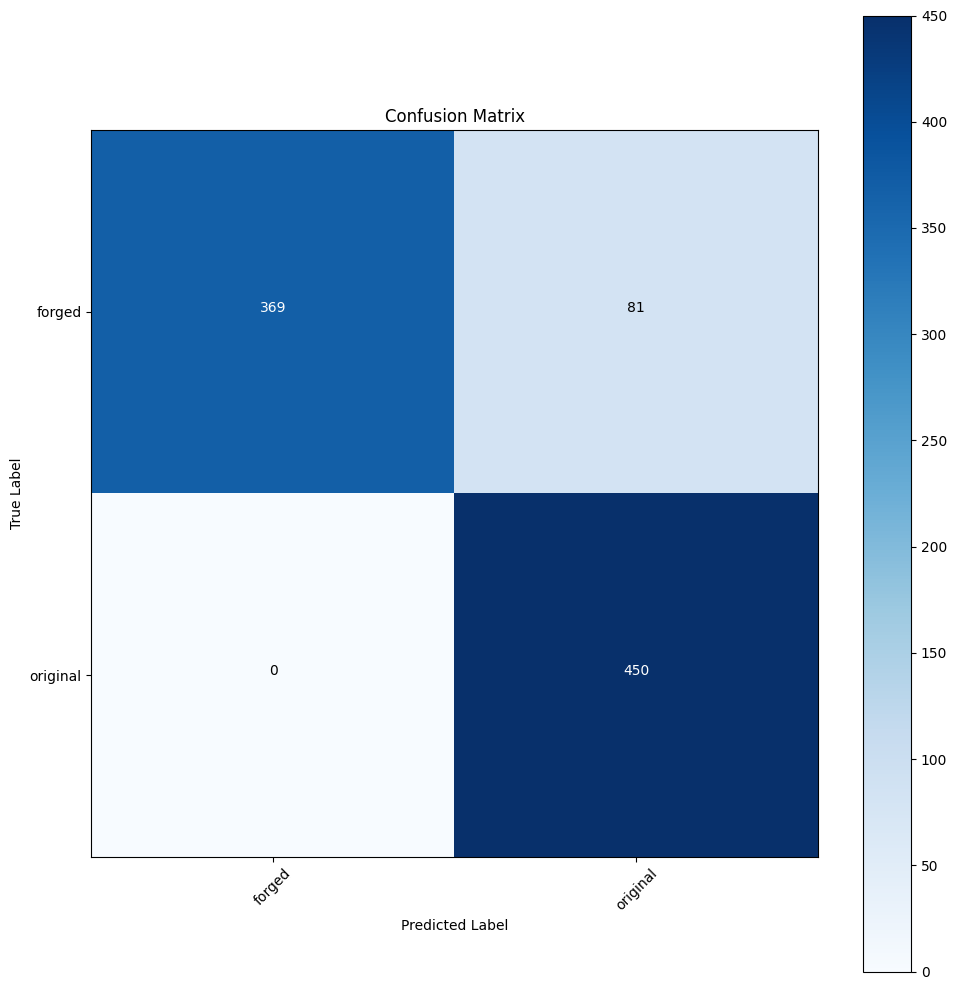

In [21]:
#Confusion Matrix dan Classification Report
Y_pred = model.predict(test)
y_pred = np.argmax(Y_pred, axis=-1)
print('confusion Matrix')
cm=confusion_matrix(test.classes, y_pred)

plot_cfx(cm, target_names, title='Confusion Matrix')
plt.savefig(f"../program/confusion_matrix.jpg")

In [22]:
print('Classification Report')
print(classification_report(test.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      forged       1.00      0.82      0.90       450
    original       0.85      1.00      0.92       450

    accuracy                           0.91       900
   macro avg       0.92      0.91      0.91       900
weighted avg       0.92      0.91      0.91       900



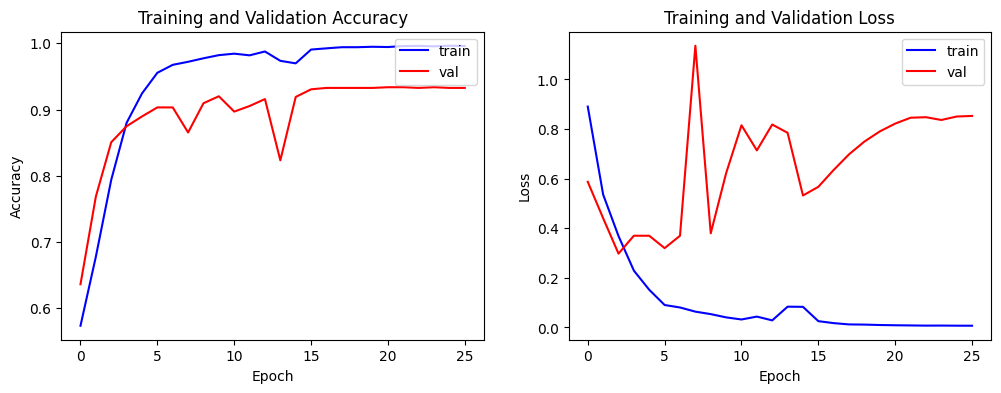

In [23]:
train_accuracy=history.history['accuracy']
val_accuracy=history.history['val_accuracy']
train_loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(train_accuracy))
plt.figure(figsize=(12,4))

#plotting the accuracy
plt.subplot(1,2,1)
plt.plot(epochs,train_accuracy,'b', label='Training Accuracy')
plt.plot(epochs,val_accuracy,'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train','val'], loc='upper right')

#plotting the loss
plt.subplot(1,2,2)
plt.plot(epochs,train_loss,'b', label='Training Loss')
plt.plot(epochs,val_loss,'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','val'], loc='upper right')

plt.show()

In [24]:
test_label = test.classes
predict_label = y_pred

result_txt = open(f"../program/result.txt", "w")
result_txt.write(f"Ellapsed Time: {ellapsed_time_string}\nEllapsed Time (seconds): {ellapsed_time.total_seconds()}\nAccuracy: {accuracy_score(test_label, predict_label)}\nF1 score - micro: {f1_score(test_label, predict_label, average='micro')}\nF1 score - macro: {f1_score(test_label, predict_label, average='macro')}\nF1 score - weighted: {f1_score(test_label, predict_label, average='weighted')}\nClassification Report:\n{classification_report(test_label, predict_label, digits=3)}")
result_txt.close()